# Лабораторная работа 4  
## Восстановление фазы несущей с CPM модуляцией
Выполнила: Шаповалова Виктория, ИКТ-11М.  

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [46]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import scipy
from scipy import signal
from scipy.signal import max_len_seq
from ModulationPy import PSKModem
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import upfirdn,lfilter
import time

### 2. Задание параметров  
В данном разделе задаются параметры, которые будут использованы в ходе выполнения работы.

In [47]:
random.seed(1)
psk_shift = np.pi/4  # Поворот созвездия
data_len = 10000  # Длина информационной последовательности
offset_phase = np.pi/6
fs = 2e6 # частота дискретизации частоты смещения
fc = 5e4 # частота несущей
sps = 10
snr = 30
b_len = 100  # Длина буфера для суммы
BT = 0.4 # коэффициент модуляции для GMSK


### 3. Генерация случайного сигнала  
В данном разделе с помощью функции рандома генерируется информационный сигнал длины data_len для дальнейшей передачи.

In [48]:
data = [] 
data = np.random.randint(2, size = data_len)

### 4. GMSK-модуляция
В данном разделе создается функция, выполняющая модуляцию GMSK (функции совпадают с функциями ЛР2).    
GMSK (гауссовская частотная модуляция с минимальным сдвигом) - это один из видов непрерывной фазовой модуляции. Последовательность из прямоугольных импульсов проходит через гауссовский фильтр нижних частот для преобразования информационного потока из вида 0/1 в вид −1/+1, а затем фильтруется гауссовым фильтром таким образом, что прямоугольные импульсы преобразуются в импульсы гауссовского вида.  
Поэтому далее в первую очередь определена функция гауссовского ФНЧ, а затем уже сама функция GMSK модуляции.

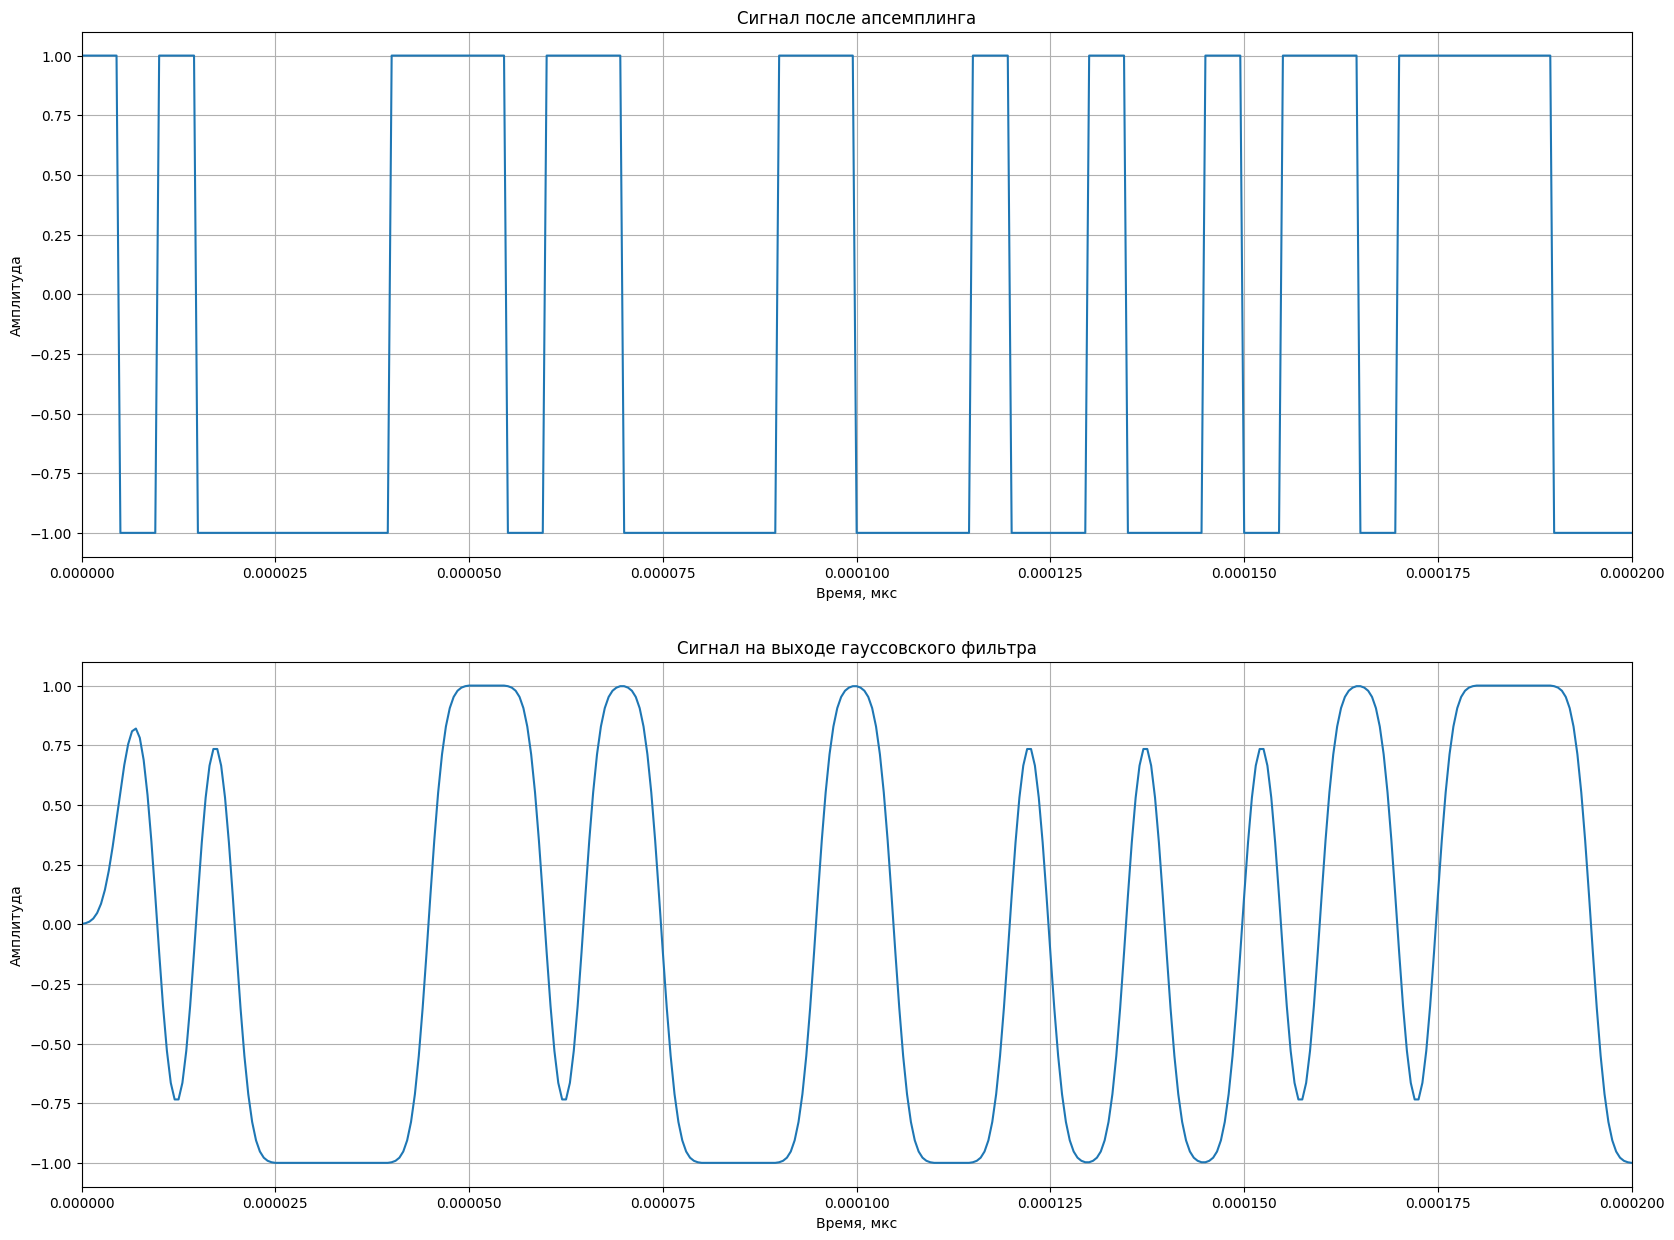

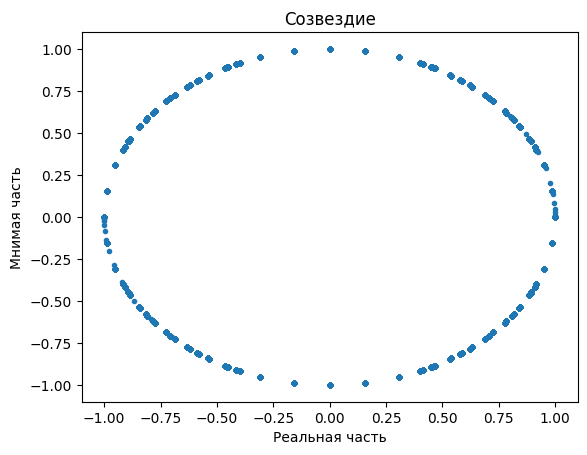

C:\Users\Victoria\AppData\Local\Temp\ipykernel_13176\909684403.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [49]:
def gaussianLPF(BT, Tb, L, k):
    B = BT/Tb # bandwidth of the filter
    t = np.arange(start = -k*Tb, stop = k*Tb + Tb/L, step = Tb/L)
    h = B*np.sqrt(2*np.pi/(np.log(2)))*np.exp(-2 * (t*np.pi*B)**2 /(np.log(2)))
    h_norm=h/np.sum(h)
    return h_norm

def gmsk_mod(a,fc,fs,L,BT):
    
    Ts = 1/fs
    Tb = L*Ts 
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L)
    k=1
    h_t = gaussianLPF(BT,Tb,L,k)
    b_t = np.convolve(h_t,c_t,'full') 
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    h = 0.5
    # integrate to get phase information
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb

    I = np.cos(phi_t)
    Q = np.sin(phi_t)
    s_complex = I - 1j*Q

    
    fig, ((ax1, ax2)) = plt.subplots(2,1, figsize=(20,15))

    ax1.title.set_text('Сигнал после апсемплинга')
    ax1.plot(np.arange(0,len(c_t))*Ts,c_t)
    ax1.set_xlabel('Время, мкс')
    ax1.set_ylabel('Амплитуда')
    ax1.set_xlim(0,40*Tb)
    ax1.grid()

    ax2.title.set_text('Сигнал на выходе гауссовского фильтра')
    ax2.plot(np.arange(0,len(bnorm_t))*Ts,bnorm_t)
    ax2.set_xlabel('Время, мкс')
    ax2.set_ylabel('Амплитуда')
    ax2.set_xlim(0,40*Tb)
    ax2.grid()

    plt.figure(3)
    plt.plot(I, Q, '.')
    plt.xlabel('Реальная часть')
    plt.ylabel('Мнимая часть')
    plt.title('Созвездие')
    plt.show()

    fig.show()
    return (s_complex)

data_mod = gmsk_mod(data, fc, fs, sps, BT)  # Модулируем данные ([0] - данные с переносом на несущую, [1] - данные без переноса)


### 5. Фазовый сдвиг  
В данном разделе реализован сдвиг по фазе. Он задается параметром offset_phase. Для данного случая сдвиг равен pi/6. СОзвездия требуются, чтобы показать наличие этого сдвига.

Text(0.5, 1.0, 'Созвездие сигнала с фазовым сдвигом')

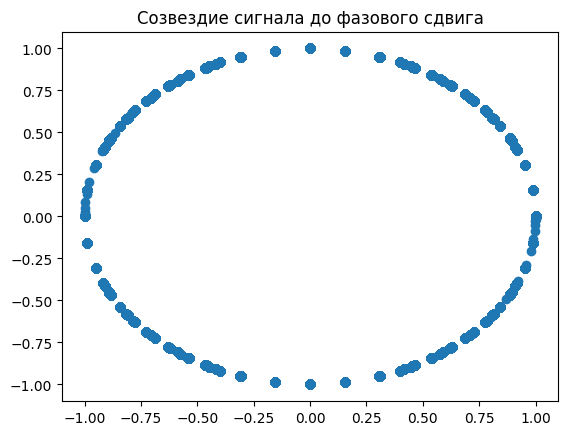

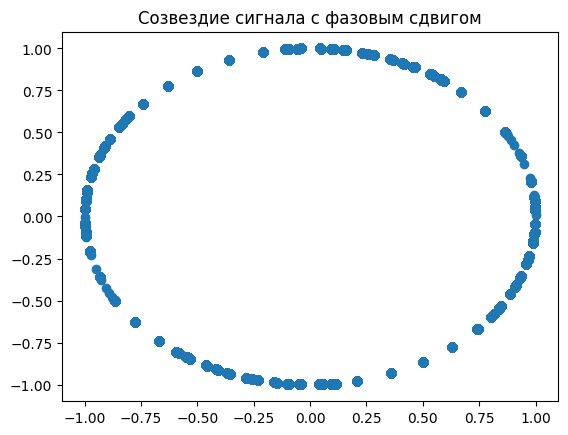

In [50]:
def phase_offset_func(data, phase):
    data = data * np.exp(1j*phase) 
    return data

data_mod_phaseof = phase_offset_func(data_mod, offset_phase)

plt.figure(0)
plt.scatter(np.real(data_mod), np.imag(data_mod))
plt.title("Созвездие сигнала до фазового сдвига")

plt.figure(1)
plt.scatter(np.real(data_mod_phaseof), np.imag(data_mod_phaseof))
plt.title("Созвездие сигнала с фазовым сдвигом")

### 6. Добавление АБГШ 
К сдвинутому сигналу добавляется АБГШ, который создается функцией awgn. Входным параметром задается отношение сигнал/шум в дБ. В данном примере оно задано 30 дБ. Созвездие требуется, чтобы показать зашумление относительно предыдущего созвездия.

Text(0.5, 0, 'Реальная часть')

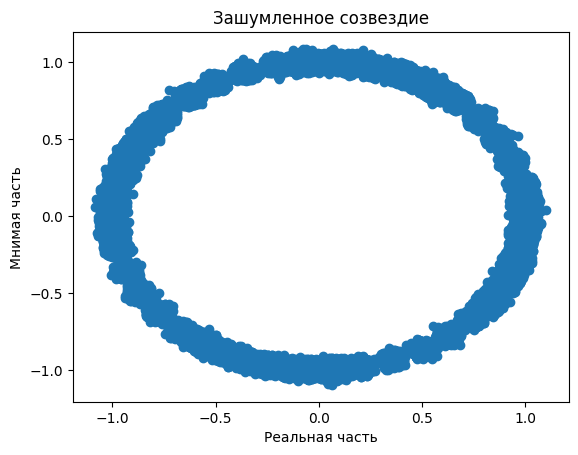

In [51]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return complex_noise

awgn_noise = awgn(data_mod_phaseof, snr)
tx = data_mod_phaseof + awgn_noise

plt.figure(1)
plt.scatter(tx.real, tx.imag)
plt.title('Зашумленное созвездие')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")

### 7. Добавление схемы синхронизации
На приемной стороне должна быть применена схема, восстанавливающая частотное и фазовое отклонение. В качестве такой схемы, не относящейся к типу схем петли Костаса, выбрана схема ML data-aided phase estimation, показанная на рисунке ниже.  
На входе схемы выборки из согласованного фильтра отбираются со скоростью 2/T, и последовательно-параллельный преобразователь (S/P) разделяет последовательности {x(k)} и {x(k +1/2)}, которые домножаются на соответствующий коэффициент и суммируются. На выходе определяется значение угла отклонения фазы.

![lab3_1.JPG](lab3_1.JPG)

Формула оценки смещения фазы несущей:
$$ \hat \theta = arg\{ \sum_{k=0}^{L_0-1}a_kx(k) - j\sum_{k=0}^{L_0-1}b_kx(k) \} $$

In [52]:
def ml_est(tx, data_mod, PHASE_EST):
    buf_counter = 0
    sum = 0

    for k in range(len(tx)):
        re_x = np.real(data_mod[k]) * tx[k]
        im_x = (-1j) * np.imag(data_mod[k]) * tx[k]
        sum += (re_x + im_x)
        buf_counter += 1
        if buf_counter == b_len:
            theta = np.angle(sum, deg=True)
            PHASE_EST = np.append(PHASE_EST, theta)
            buf_counter = 0
            sum = 0
    return(PHASE_EST)

PHASE_EST = np.array([]) 
PHASE_EST = ml_est(tx, data_mod, PHASE_EST)

print("Среднее значение смещения фазы: ", np.round(np.mean(PHASE_EST), decimals=3), "°")
print("Ошибка вычисления фазы: ",np.round(np.rad2deg(offset_phase)-np.mean(PHASE_EST), decimals=3), "°")


Среднее значение смещения фазы:  29.997 °
Ошибка вычисления фазы:  0.003 °


### 8. Анализ схемы ML data-aided phase estimation
В данном разделе исследована зависимость модуля величины ошибки вычисления фазового смещения от SNR. 
По графику видно, что с увеличением отношения сигнал/шум ошибка оценки фазы уменьшается по экспоненциальному закону.

Text(0, 0.5, 'Ошибка оценки фазового смещения')

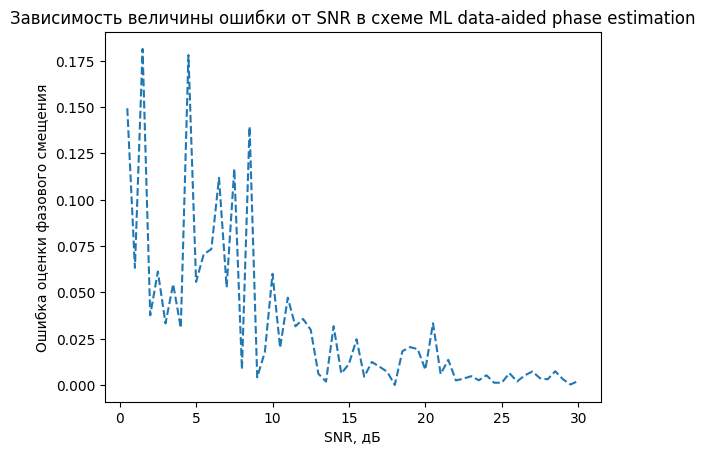

In [54]:
ERRS_ML = [] 

for i in range(1, 61, 1):
    awgn_noise = awgn(data_mod_phaseof, i/2)
    tx = data_mod_phaseof + awgn_noise
    PHASE_EST = np.array([]) 
    PHASE_EST = ml_est(tx, data_mod, PHASE_EST)
    err = np.rad2deg(offset_phase)-np.mean(PHASE_EST)
    ERRS_ML.append(err)


plt.figure(0)
snrs = np.arange(1, 61)
plt.plot(snrs/2, np.abs(ERRS_ML), '--')
plt.title('Зависимость величины ошибки от SNR в схеме ML data-aided phase estimation')
plt.xlabel('SNR, дБ')
plt.ylabel('Ошибка оценки фазового смещения')

## Вывод  
В ходе выполнения лабораторной работы была сформирована информационная последовательность, которая была промодулирована непрерывной фазовой модуляцией GMSK. Затем модулированная последовательность была подвержена воздействию частотного сдвига и АБГШ. Далее была произведена оценка смещения с помощью схемы ML data-aided phase estimation. Схема вычисляет и выдает значение угла отклонения фазы, поэтому для нее была исследована зависимость модуля величины ошибки вычисления фазового смещения от SNR. В результате было определено, что с увеличением отношения сигнал/шум ошибка оценки фазы уменьшается по экспоненциальному закону.  